In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import autograd
import torch.nn.functional as F
import random

In [10]:
images1 = np.load("cs475_project_data/images.npy")
num_images, height, width = images1.shape
images1 = images1.reshape(num_images, height*width) #reshape
labels1 = np.load("cs475_project_data/labels.npy")

images = torch.from_numpy(images1)
labels = torch.from_numpy(labels1).type(torch.IntTensor) # make sure int values

images = images.type(torch.DoubleTensor)
images = (images - torch.mean(images))/torch.std(images)
# the above normalizes the data based on z score

In [11]:
# split data
train_data = images[:40000]
dev_data = images[40000:45000]
test_data = images[45000:]

train_labels = labels[:40000]
dev_labels = labels[40000:45000]
test_labels = labels[45000:]

HEIGHT = 26
WIDTH = 26
NUM_CLASSES = 5
NUM_OPT_STEPS = 5000

In [12]:
class ConvNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 3x3 convolution that takes in an image with one channel
        # and outputs an image with 8 channels.
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3)
        # 3x3 convolution that takes in an image with 8 channels
        # and outputs an image with 16 channels. The output image
        # has approximately half the height and half the width
        # because of the stride of 2.
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=2)
        # 1x1 convolution that takes in an image with 16 channels and
        # produces an image with 5 channels. Here, the 5 channels
        # will correspond to class scores.
        self.final_conv = torch.nn.Conv2d(32, 5, kernel_size=1)
    def forward(self, x):
        # Convolutions work with images of shape
        # [batch_size, num_channels, height, width]
        x = x.view(-1, HEIGHT, WIDTH).unsqueeze(1)
        x = F.relu(self.conv1(x)).clamp(min=0)
        x = F.relu(self.conv2(x)).clamp(min=0)
        n, c, h, w = x.size()
        x = F.avg_pool2d(x, kernel_size=[h, w])
        x = self.final_conv(x).view(-1, NUM_CLASSES)
        return x

In [13]:
model = ConvNN()

optimizer = torch.optim.Adam(model.parameters(), lr=.01)

In [14]:
def train(batch_size):
    # model.train() puts our model in train mode, which can require different
    # behavior than eval mode (for example in the case of dropout).
    model.train()
    # i is is a 1-D array with shape [batch_size]
    i = np.random.choice(train_data.shape[0], size=batch_size, replace=False)
    temp = train_data.numpy()
    temp1 = train_labels.numpy()
    x = autograd.Variable(torch.from_numpy(temp[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(temp1[i].astype(np.int)))
    optimizer.zero_grad()
    y_hat_ = model(x)
    loss = F.cross_entropy(y_hat_, y)
    loss.backward()
    optimizer.step()
    return loss.data[0]

In [15]:
def approx_train_accuracy():
    i = np.random.choice(train_data.shape[0], size=1000, replace=False)
    tempy = train_data.numpy()
    tempy1 = train_labels.numpy()
    x = autograd.Variable(torch.from_numpy(tempy[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(tempy1[i].astype(np.int)))
    y_hat_ = model(x)
    #print(y)
    y = y.data.numpy()
    y_hat_ = y_hat_.data.numpy()
    y_hat_ = np.argmax(y_hat_, axis=1)
    #print(y_hat_)
    return (y == y_hat_).astype(np.float).mean()

def val_accuracy():
    i = np.random.choice(dev_data.shape[0], size=5000, replace=False)
    tempy2 = dev_data.numpy()
    tempy3 = dev_labels.numpy()
    x = autograd.Variable(torch.from_numpy(tempy2[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(tempy3[i].astype(np.int)))
    y_hat_ = model(x)
    #print(y)
    y = y.data.numpy()
    y_hat_ = y_hat_.data.numpy()
    y_hat_ = np.argmax(y_hat_, axis=1)
    #print(y_hat_)
    return (y == y_hat_).astype(np.float).mean()

In [16]:
train_accs, val_accs = [], []
iterations = []
print("Using model with initial, unadjusted optimizer and learning rate") #100, .01, 5000 --> 88%
for i in range(NUM_OPT_STEPS):
    train(100)
    if i % 100 == 0:
        iterations.append(i)
        train_accs.append(approx_train_accuracy())
        val_accs.append(val_accuracy())
        print("%6d %5.2f %5.2f" % (i, train_accs[-1], val_accs[-1]))

Using model with initial, unadjusted optimizer and learning rate
     0  0.22  0.21
   100  0.68  0.67
   200  0.64  0.66
   300  0.72  0.74
   400  0.76  0.77
   500  0.77  0.77
   600  0.78  0.78
   700  0.80  0.79
   800  0.81  0.81
   900  0.73  0.77
  1000  0.80  0.81
  1100  0.82  0.81
  1200  0.80  0.82
  1300  0.83  0.84
  1400  0.83  0.84
  1500  0.83  0.82
  1600  0.83  0.82
  1700  0.80  0.81
  1800  0.84  0.84
  1900  0.83  0.84
  2000  0.85  0.85
  2100  0.82  0.83
  2200  0.82  0.84
  2300  0.84  0.85
  2400  0.85  0.85
  2500  0.84  0.83
  2600  0.86  0.86
  2700  0.85  0.86
  2800  0.85  0.85
  2900  0.85  0.84
  3000  0.86  0.86
  3100  0.83  0.85
  3200  0.86  0.85
  3300  0.86  0.85
  3400  0.88  0.87
  3500  0.86  0.87
  3600  0.88  0.86
  3700  0.87  0.87
  3800  0.87  0.87
  3900  0.88  0.87
  4000  0.88  0.87
  4100  0.86  0.85
  4200  0.86  0.86
  4300  0.85  0.84
  4400  0.88  0.88
  4500  0.87  0.86
  4600  0.87  0.87
  4700  0.88  0.87
  4800  0.86  0.86
  49

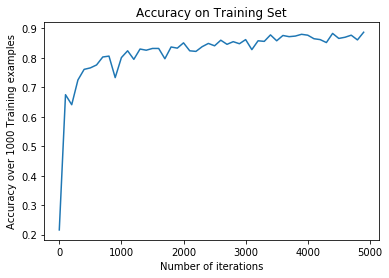

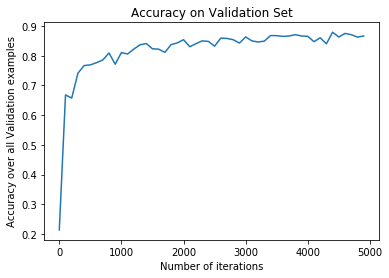

In [17]:
plt.plot(iterations, train_accs)
plt.title("Accuracy on Training Set")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy over 1000 Training examples")
plt.show()

plt.plot(iterations, val_accs)
plt.title("Accuracy on Validation Set")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy over all Validation examples")
plt.show()

The above graphs respresents a conv NN with double the number of filters.

In [18]:
class ConvNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 3x3 convolution that takes in an image with one channel
        # and outputs an image with 8 channels.
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3, stride=1)
        # 3x3 convolution that takes in an image with 8 channels
        # and outputs an image with 16 channels. The output image
        # has approximately half the height and half the width
        # because of the stride of 2.
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1)
        # 1x1 convolution that takes in an image with 16 channels and
        # produces an image with 5 channels. Here, the 5 channels
        # will correspond to class scores.
        self.final_conv = torch.nn.Conv2d(32, 5, kernel_size=1)
    def forward(self, x):
        # Convolutions work with images of shape
        # [batch_size, num_channels, height, width]
        x = x.view(-1, HEIGHT, WIDTH).unsqueeze(1)
        x = F.relu(self.conv1(x)).clamp(min=0)
        x = F.relu(self.conv2(x)).clamp(min=0)
        n, c, h, w = x.size()
        x = F.avg_pool2d(x, kernel_size=[h, w])
        x = self.final_conv(x).view(-1, NUM_CLASSES)
        return x

In [19]:
model = ConvNN()

optimizer = torch.optim.Adam(model.parameters(), lr=.01)

In [20]:
def train(batch_size):
    # model.train() puts our model in train mode, which can require different
    # behavior than eval mode (for example in the case of dropout).
    model.train()
    # i is is a 1-D array with shape [batch_size]
    i = np.random.choice(train_data.shape[0], size=batch_size, replace=False)
    temp = train_data.numpy()
    temp1 = train_labels.numpy()
    x = autograd.Variable(torch.from_numpy(temp[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(temp1[i].astype(np.int)))
    optimizer.zero_grad()
    y_hat_ = model(x)
    loss = F.cross_entropy(y_hat_, y)
    loss.backward()
    optimizer.step()
    return loss.data[0]

In [21]:
def approx_train_accuracy():
    i = np.random.choice(train_data.shape[0], size=1000, replace=False)
    tempy = train_data.numpy()
    tempy1 = train_labels.numpy()
    x = autograd.Variable(torch.from_numpy(tempy[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(tempy1[i].astype(np.int)))
    y_hat_ = model(x)
    #print(y)
    y = y.data.numpy()
    y_hat_ = y_hat_.data.numpy()
    y_hat_ = np.argmax(y_hat_, axis=1)
    #print(y_hat_)
    return (y == y_hat_).astype(np.float).mean()

def val_accuracy():
    i = np.random.choice(dev_data.shape[0], size=5000, replace=False)
    tempy2 = dev_data.numpy()
    tempy3 = dev_labels.numpy()
    x = autograd.Variable(torch.from_numpy(tempy2[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(tempy3[i].astype(np.int)))
    y_hat_ = model(x)
    #print(y)
    y = y.data.numpy()
    y_hat_ = y_hat_.data.numpy()
    y_hat_ = np.argmax(y_hat_, axis=1)
    #print(y_hat_)
    return (y == y_hat_).astype(np.float).mean()

In [22]:
train_accs, val_accs = [], []
iterations = []
print("With stride of 1") #100, .01, 5000 --> 88%
for i in range(NUM_OPT_STEPS):
    train(100)
    if i % 100 == 0:
        iterations.append(i)
        train_accs.append(approx_train_accuracy())
        val_accs.append(val_accuracy())
        print("%6d %5.2f %5.2f" % (i, train_accs[-1], val_accs[-1]))

With stride of 1
     0  0.23  0.21
   100  0.66  0.64
   200  0.70  0.71
   300  0.74  0.74
   400  0.74  0.76
   500  0.77  0.78
   600  0.77  0.77
   700  0.80  0.80
   800  0.79  0.77
   900  0.78  0.79
  1000  0.81  0.81
  1100  0.81  0.82
  1200  0.80  0.80
  1300  0.82  0.81
  1400  0.84  0.83
  1500  0.81  0.83
  1600  0.83  0.84
  1700  0.80  0.81
  1800  0.83  0.84
  1900  0.84  0.83
  2000  0.85  0.84
  2100  0.84  0.85
  2200  0.83  0.83
  2300  0.84  0.85
  2400  0.84  0.84
  2500  0.86  0.86
  2600  0.69  0.72
  2700  0.82  0.82
  2800  0.80  0.80
  2900  0.86  0.85
  3000  0.86  0.86
  3100  0.85  0.86
  3200  0.85  0.85
  3300  0.83  0.85
  3400  0.83  0.85
  3500  0.84  0.86
  3600  0.82  0.85
  3700  0.85  0.88
  3800  0.86  0.86
  3900  0.86  0.87
  4000  0.87  0.88
  4100  0.87  0.88
  4200  0.86  0.87
  4300  0.87  0.88
  4400  0.89  0.88
  4500  0.83  0.86
  4600  0.86  0.88
  4700  0.86  0.86
  4800  0.87  0.88
  4900  0.87  0.88


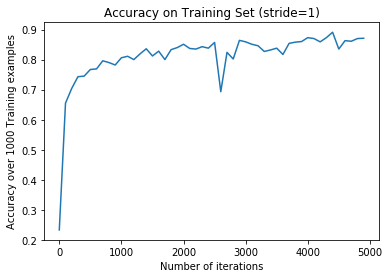

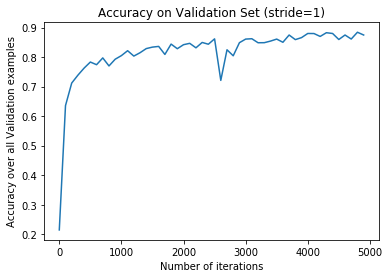

In [23]:
plt.plot(iterations, train_accs)
plt.title("Accuracy on Training Set (stride=1)")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy over 1000 Training examples")
plt.show()

plt.plot(iterations, val_accs)
plt.title("Accuracy on Validation Set (stride=1)")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy over all Validation examples")
plt.show()

The above graphs represent a conv NN with stride of 1 at all layers.

In [65]:
class ConvNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 3x3 convolution that takes in an image with one channel
        # and outputs an image with 8 channels.
        self.conv1 = torch.nn.Conv2d(1, 16, kernel_size=3, stride=2)
        # 3x3 convolution that takes in an image with 8 channels
        # and outputs an image with 16 channels. The output image
        # has approximately half the height and half the width
        # because of the stride of 2.
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=2)
        # 1x1 convolution that takes in an image with 16 channels and
        # produces an image with 5 channels. Here, the 5 channels
        # will correspond to class scores.
        self.final_conv = torch.nn.Conv2d(32, 5, kernel_size=1)
    def forward(self, x):
        # Convolutions work with images of shape
        # [batch_size, num_channels, height, width]
        x = x.view(-1, HEIGHT, WIDTH).unsqueeze(1)
        x = F.relu(self.conv1(x)).clamp(min=0)
        x = F.relu(self.conv2(x)).clamp(min=0)
        n, c, h, w = x.size()
        x = F.avg_pool2d(x, kernel_size=[h, w])
        x = self.final_conv(x).view(-1, NUM_CLASSES)
        return x

In [66]:
model = ConvNN()

optimizer = torch.optim.Adam(model.parameters(), lr=.01)

In [67]:
def train(batch_size):
    # model.train() puts our model in train mode, which can require different
    # behavior than eval mode (for example in the case of dropout).
    model.train()
    # i is is a 1-D array with shape [batch_size]
    i = np.random.choice(train_data.shape[0], size=batch_size, replace=False)
    temp = train_data.numpy()
    temp1 = train_labels.numpy()
    x = autograd.Variable(torch.from_numpy(temp[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(temp1[i].astype(np.int)))
    optimizer.zero_grad()
    y_hat_ = model(x)
    loss = F.cross_entropy(y_hat_, y)
    loss.backward()
    optimizer.step()
    return loss.data[0]

In [68]:
def approx_train_accuracy():
    i = np.random.choice(train_data.shape[0], size=1000, replace=False)
    tempy = train_data.numpy()
    tempy1 = train_labels.numpy()
    x = autograd.Variable(torch.from_numpy(tempy[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(tempy1[i].astype(np.int)))
    y_hat_ = model(x)
    #print(y)
    y = y.data.numpy()
    y_hat_ = y_hat_.data.numpy()
    y_hat_ = np.argmax(y_hat_, axis=1)
    #print(y_hat_)
    return (y == y_hat_).astype(np.float).mean()

def val_accuracy():
    i = np.random.choice(dev_data.shape[0], size=5000, replace=False)
    tempy2 = dev_data.numpy()
    tempy3 = dev_labels.numpy()
    x = autograd.Variable(torch.from_numpy(tempy2[i].astype(np.float32)))
    y = autograd.Variable(torch.from_numpy(tempy3[i].astype(np.int)))
    y_hat_ = model(x)
    #print(y)
    y = y.data.numpy()
    y_hat_ = y_hat_.data.numpy()
    y_hat_ = np.argmax(y_hat_, axis=1)
    #print(y_hat_)
    return (y == y_hat_).astype(np.float).mean()

In [69]:
train_accs, val_accs = [], []
iterations = []
NUM_OPT_STEPS = 5000
print("With stride of 2") #100, .01, 5000 --> 89%
for i in range(NUM_OPT_STEPS):
    train(100)
    if i % 100 == 0:
        iterations.append(i)
        train_accs.append(approx_train_accuracy())
        val_accs.append(val_accuracy())
        print("%6d %5.2f %5.2f" % (i, train_accs[-1], val_accs[-1]))

With stride of 2
     0  0.23  0.20
   100  0.69  0.69
   200  0.73  0.74
   300  0.80  0.80
   400  0.80  0.82
   500  0.76  0.79
   600  0.81  0.83
   700  0.81  0.80
   800  0.81  0.83
   900  0.84  0.83
  1000  0.82  0.81
  1100  0.83  0.85
  1200  0.84  0.85
  1300  0.85  0.85
  1400  0.84  0.85
  1500  0.82  0.84
  1600  0.86  0.85
  1700  0.84  0.86
  1800  0.85  0.85
  1900  0.86  0.86
  2000  0.87  0.85
  2100  0.86  0.86
  2200  0.87  0.86
  2300  0.87  0.87
  2400  0.86  0.85
  2500  0.88  0.87
  2600  0.90  0.86
  2700  0.88  0.86
  2800  0.86  0.86
  2900  0.85  0.86
  3000  0.85  0.87
  3100  0.89  0.87
  3200  0.86  0.87
  3300  0.84  0.86
  3400  0.89  0.88
  3500  0.89  0.88
  3600  0.88  0.87
  3700  0.91  0.88
  3800  0.89  0.88
  3900  0.88  0.87
  4000  0.89  0.87
  4100  0.88  0.86
  4200  0.88  0.88
  4300  0.88  0.87
  4400  0.89  0.87
  4500  0.89  0.88
  4600  0.87  0.87
  4700  0.90  0.89
  4800  0.88  0.88
  4900  0.89  0.88


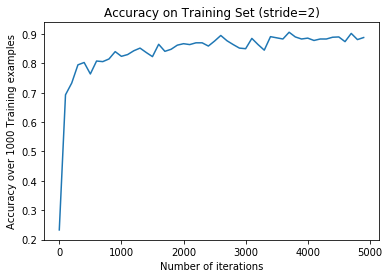

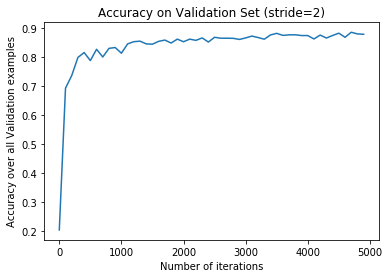

In [70]:
plt.plot(iterations, train_accs)
plt.title("Accuracy on Training Set (stride=2)")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy over 1000 Training examples")
plt.show()

plt.plot(iterations, val_accs)
plt.title("Accuracy on Validation Set (stride=2)")
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy over all Validation examples")
plt.show()

The best validation accuracy I obtained was 89%. The configuration that led to this performance was the convolutional NN with a stride length of 2, with number of optimal steps equaling 5000, learning rate of .01, and batch size of 100. I do not think I am necessarily underfitting or overfitting in this case; I am not overfitting because the accuracy on both the training/validation sets is relatively the same, and I do not think I am underfitting because the model's performance is relatively good on the training set. 

In order to increase the performance of my convolutional NN, I could try a couple different things. For one, I could alter the stride length of the layers to see if there would be an effect on receptive field of the future layers, and also speed up the time it takes for the model to run. I could also adjust the learning rates for these new models, add more layers to see if this would effect the performance, and increase the number of optimal steps to see if the model is still learning with increased iteration. 